Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

**Deadline**

T.b.d.


In [180]:
import logging
import random
from collections import namedtuple
import copy
from math import ceil, sqrt, exp, isclose
from typing import Callable
from itertools import accumulate
import operator
import matplotlib.pyplot as plt
from statistics import stdev, mean

In [181]:
N_HEAPS = 3
N_GAMES = 100

In [182]:
logging.basicConfig(level=logging.DEBUG)
random.seed(13)

In [183]:
class Player:
    def __init__(self, name:str, strategy:Callable, *strategy_args):
        self._strategy = strategy
        self._strategy_args = strategy_args
        self._name = name
        self._loser = False
        self._n_plies = 0
    
    def ply(self, state):
        self._strategy(self, state, *self._strategy_args)
        self._n_plies += 1
    
    @property
    def loser(self):
        return self._loser
    
    @loser.setter
    def loser(self, val):
        self._loser = val
    
    @property
    def name(self):
        return self._name
    
    @property
    def n_plies(self):
        return self._n_plies
    
    @n_plies.setter
    def n_plies(self, val):
        self._n_plies = val
    
    def flush_parameters(self):
        self._n_plies = 0
        self._loser = False

class Nim:
    def __init__(self, num_rows: int=None, rows:list=None, k: int = None) -> None:
        if num_rows is not None:
            self._rows = [i*2 + 1 for i in range(num_rows)]
        else:
            self._rows = rows
        self._k = k

    def nimming(self, row: int, num_objects: int, player:Player) -> None:
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        if sum(self._rows) == 0:
            player.loser = True
    
    @property
    def rows(self):
        return self._rows
    
    def copy(self):
        return copy.deepcopy(self)


def play(A:Player, B:Player, state:Nim) -> Player:
    #logging.debug(f"{state.rows} : initial state")
    while not (A.loser or B.loser):
        A.ply(state)
        #logging.debug(f"{state.rows} : state after {A.name} ply")
        if not A.loser:
            B.ply(state)
            #logging.debug(f"{state.rows} : state after {B.name} ply")
    if A.loser:
        return B
    elif B.loser:
        return A

def match(A:Player, B:Player, state:Nim, n_games:int=1):
    winners = list()
    for i in range(n_games):
        initial_state = state.copy()
        A.flush_parameters()
        B.flush_parameters()
        r = random.random()
        if r <= 0.5:
            w = play(A, B, initial_state)
        else:
            w = play(B, A, initial_state)
        winners.append((w.name, w.n_plies))
    return winners

def print_match_result(A:Player, B:Player, res:list):
    n_A_win = 0
    n_games = len(res)
    for i in range(n_games):
        if res[i][0] == A.name:
            n_A_win += 1
    print(f"{A.name} won {n_A_win} times\n{B.name} won {n_games - n_A_win} times") 
    
def random_strategy(player:Player, heaps:Nim, decrement:bool=False):
    non_zero_heaps_idxs = [i for i, v in enumerate(heaps.rows) if v > 0] # choose a random non-zero heap
    idx_heap = random.choice(non_zero_heaps_idxs)
    if decrement:
        quantity = 1
    else:
        quantity = random.randint(1, heaps.rows[idx_heap]) # decrease it of a random quantity
    heaps.nimming(idx_heap, quantity, player)


## Task3.1 Nim-Sum

In [184]:
def nim_sum(l:list):
    sum = 0
    for _, v in enumerate(l):
        sum ^= v
    return sum

def nim_sum_strategy(player:Player, heaps: Nim):
    if sum(heaps.rows) == 0:
        raise Exception("There is no heap left!")
        
    n_heaps = len(heaps.rows)
    n_heaps_to_zero = len([i for i, h in enumerate(heaps.rows) if h == 0])
    n_heaps_to_one = len([i for i, h in enumerate(heaps.rows) if h == 1])
    n_heaps_greater_than_zero = n_heaps - n_heaps_to_zero
    n_heaps_greater_than_one = n_heaps_greater_than_zero - n_heaps_to_one

    # manage particular situations
    if n_heaps_greater_than_zero % 2 == 0 and n_heaps_greater_than_one == 1: #[1, a, 1, 1, 0, 0], a > 1
        # take all objects from the heap with more than 1 object
        heaps.nimming(heaps.rows.index(max(heaps.rows)), max(heaps.rows), player)
    elif n_heaps_greater_than_zero % 2 == 1 and n_heaps_greater_than_one == 1: #[1, a, 1, 0, 0], a > 1
        # take all objects but 1 from the heap with more than 1 object
        heaps.nimming(heaps.rows.index(max(heaps.rows)), max(heaps.rows)-1, player)
    elif n_heaps_greater_than_one == 1 and n_heaps_to_one == 0: #[a, 0, 0], a > 1
        # take all objects but 1 from the last non zero heap with more than 1 object
        heaps.nimming(heaps.rows.index(max(heaps.rows)), max(heaps.rows)-1, player)
    elif n_heaps_greater_than_one == 0 and n_heaps_to_one > 0:   #[1, 0, 1, 1]
        # take one object from the first heap
        heaps.nimming(heaps.rows.index(1), 1, player)
    elif n_heaps_greater_than_one == 2 and n_heaps_to_one == 0: #[0, a, b, 0, ..., 0], a, b > 1, a < b
        # reduce the highest heap to the same height as the other
        max_heap = max(heaps.rows)
        max_heap_idx = heaps.rows.index(max_heap)
        min_heap = min(heaps.rows)
        heaps.nimming(max_heap_idx, max_heap - min_heap, player )
    else:  # normal game
        x = nim_sum(heaps.rows)
        y = [nim_sum([x, h]) for _, h in enumerate(heaps.rows)]
        winning_heaps = [i for i, h in enumerate(heaps.rows) if y[i] < h]
        if len(winning_heaps) > 0: # if there's a winning heap
            chosen_heap_idx = random.choice(winning_heaps)
            heaps.nimming(chosen_heap_idx, heaps.rows[chosen_heap_idx]-y[chosen_heap_idx], player)
        else: # take one object from a random heap 
            random_strategy(player, heaps, decrement=True)

In [185]:
# trying nim-sum vs random strategy
heaps = Nim(N_HEAPS)
Alice = Player("Alice", nim_sum_strategy)
Bob = Player("Bob", random_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)



Alice won 83 times
Bob won 17 times


In [186]:
# trying nim-sum vs nim-sum startegy
heaps = Nim(N_HEAPS)
Alice = Player("Alice", nim_sum_strategy)
Bob = Player("Bob", nim_sum_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice won 40 times
Bob won 60 times


## Task3.2 Evolved Rules

In [187]:
GEN_NUM = 20
POP_SIZE = 50
OFFSPR_NUM = 5*POP_SIZE


In [188]:
class Genome:
    def __init__(self, pr_heap: list, pr_obj: list, step_size: float, fitness: float = None):
        self._pr_heap = pr_heap
        self._pr_obj = pr_obj
        self._step_size = step_size
        self._fitness = fitness

    @property
    def pr_heap(self):
        return self._pr_heap

    @property
    def pr_obj(self):
        return self._pr_obj

    @property
    def step_size(self):
        return self._step_size

    @step_size.setter
    def step_size(self, val):
        if val < 0:
            self._step_size = 0
        else:
            self._step_size = val

    @property
    def fitness(self):
        return self._fitness

    @fitness.setter
    def fitness(self, val):
        self._fitness = val

    def mutate(self):
        mutated_pr_heap = list()
        mutated_pr_obj = list()
        for h, o in zip(self._pr_heap, self._pr_obj):
            mh = h + self._step_size*random.gauss(0, 1)
            if mh > 1:
                mh = 1
            elif mh < 0:
                mh = 0
            mo = o + self._step_size*random.gauss(0, 1)
            if mo > 1:
                mo = 1
            elif mo < 0:
                mo = 0
            mutated_pr_heap.append(mh)
            mutated_pr_obj.append(mo)
        self._pr_heap = mutated_pr_heap
        self._pr_obj = mutated_pr_obj


def initialization(pop_size: int, heaps: Nim, n_games: int = 10) -> list:
    # each gene correspond to a ply
    # so it must be large enough for the max number of plies
    genome_size = ceil(sum(heaps.rows)/2)
    population = list()

    for _ in range(pop_size):
        pr_heap = [random.random() for _ in range(genome_size)]
        pr_obj = [random.random() for _ in range(genome_size)]
        step_size = random.random()
        g = Genome(pr_heap, pr_obj, step_size, None)
        g.fitness = fitness(g, heaps, nim_sum_strategy, n_games)
        population.append(g)

    return population


class EvolutionalPlayer(Player):
    def __init__(self, name: str, genome: Genome, strategy: Callable):
        super().__init__(name, strategy)
        self._genome = genome

    @property
    def genome(self):
        return self._genome


def evolved_strategy(player: EvolutionalPlayer, heaps: Nim):
    ply_pr_heap = player.genome.pr_heap[player.n_plies]
    ply_pr_obj = player.genome.pr_obj[player.n_plies]

    non_zero_heaps = [(i, h) for i, h in enumerate(heaps.rows) if h > 0]
    avg_heap_size = sum([t[1] for t in non_zero_heaps])/len(non_zero_heaps)
    shortest_heaps = [t for t in non_zero_heaps if t[1] <= avg_heap_size]
    tallest_heaps = [t for t in non_zero_heaps if t[1] > avg_heap_size]

    r = random.random()
    if len(tallest_heaps) > 0 and r < ply_pr_heap:
        chosen_heap = random.choice(tallest_heaps)
    else:
        chosen_heap = random.choice(shortest_heaps)

    s = random.random()
    if chosen_heap[1] > 1 and s < ply_pr_obj:
        heaps.nimming(chosen_heap[0], random.randint(
            1, chosen_heap[1]), player)
    else:
        heaps.nimming(chosen_heap[0], 1, player)


def fitness(individual: Genome, heaps: Nim, strategy: Callable, n_games: int = 10) -> float:
    this_player = EvolutionalPlayer(
        "this_player", individual, evolved_strategy)
    opponent = Player("opponent", strategy)
    winners = match(this_player, opponent, heaps, n_games)
    n_win = 0
    for w in winners:
        if w[0] == "this_player":
            n_win += 1
    return n_win/n_games

# mean fitness, best fitness, std dev of fitness
def statistics(population: list) -> tuple:
    pop_fitness = [i.fitness for i in population]
    best = max(population, key=lambda p: p.fitness)
    return mean(pop_fitness), best.fitness, stdev(pop_fitness)


def stochastic_universal_sampling(parents: list, sel_prob: list, offspr_num: int):
    if offspr_num >= len(parents):
        return parents
    mating_pool = list()
    a = list(accumulate(sel_prob, func=operator.add))
    cur_member = 0
    i = 0
    r = random.uniform(0, 1/offspr_num)
    while cur_member < offspr_num:
        while r <= a[i]:
            mating_pool.append(parents[i])
            r += 1/offspr_num
            cur_member += 1
        i += 1
    return mating_pool


def parent_selection(population: list, offspr_size: int, s: float = 1.5) -> list:
    population.sort(key=lambda g: g.fitness)
    mu = len(population)
    sel_prob = [(2-s)/mu + 2*r*(s-1)/(mu*(mu-1))
                for r, g in enumerate(population)]
    return stochastic_universal_sampling(population, sel_prob, offspr_size)


# self-adaptive mutation
def mutation(offsprings: list, pop_size: int, k: float = 1) -> list:
    tau = k/sqrt(pop_size)
    for o in offsprings:
        o.step_size = o.step_size*exp(tau*random.gauss(0, 1))
        o.mutate()
    return offsprings


def arithmetic_crossover(parent_1: Genome, parent_2: Genome, alpha: float = 0.5) -> tuple:

    c1_heap_pr = [alpha*h1 + (1-alpha)*h2 for h1,
                  h2 in zip(parent_1.pr_heap, parent_2.pr_heap)]
    c1_obj_pr = [alpha*o1 + (1-alpha)*o2
                 for o1, o2 in zip(parent_1.pr_obj, parent_2.pr_obj)]
    c1_step_size = alpha*parent_1.step_size + (1-alpha)*parent_2.step_size

    c2_heap_pr = [alpha*h2 + (1-alpha)*h1 for h1,
                  h2 in zip(parent_1.pr_heap, parent_2.pr_heap)]
    c2_obj_pr = [alpha*o2 + (1-alpha)*o1 for o1,
                 o2 in zip(parent_1.pr_obj, parent_2.pr_obj)]
    c2_step_size = alpha*parent_2.step_size + (1-alpha)*parent_1.step_size

    return Genome(c1_heap_pr, c1_obj_pr, c1_step_size), Genome(c2_heap_pr, c2_obj_pr, c2_step_size)


def recombination(mating_pool: list, offspr_num: int, alpha: float = 0.5) -> list:
    offsprings = list()
    for _ in range(int(offspr_num/2)):
        p1, p2 = tuple(random.choices(mating_pool, k=2))
        c1, c2 = arithmetic_crossover(p1, p2, alpha)
        offsprings.append(c1)
        offsprings.append(c2)
    return offsprings



def survivor_selection(population: list, offsprings: list, heaps: Nim, n_games: int = 10) -> list:
    #(μ, λ) selection + elitism
    pop_size = len(population)
    elite_fitness = max(population, key=lambda g:g.fitness).fitness # gather the elites
    elites = [g for g in population if isclose(g.fitness, elite_fitness, abs_tol=5e-2)]
    for o in offsprings:  # compute fitness of the offspring
        o.fitness = fitness(o, heaps, nim_sum_strategy, n_games)
    for e in elites:    # add the elites to the next generation
        offsprings.append(e)
    # sort in decreasing order of fitness
    offsprings.sort(key=lambda o: o.fitness, reverse=True)
    return offsprings[0:pop_size]  # return only the fittest


def plot_stats(stats: list):
    g = list(range(len(stats)))
    mean_fitness = [v[0] for v in stats]
    best_fitness = [v[1] for v in stats]
    stddev_fitness = [v[2] for v in stats]
    plt.figure()
    plt.plot(g, mean_fitness, label="mean fitness")
    plt.plot(g, best_fitness, label="best fitness")
    plt.plot(g, stddev_fitness, label="std dev fitness")
    plt.xlim((0, len(stats)))
    plt.xlabel("generation")
    plt.ylabel("fitness")
    plt.legend()
    plt.show()

def extinction(population: list, heaps: Nim, survivor_frac: float = 0.5) -> list:
    pop_size = len(population)
    survivors = random.choices(population, k=int(pop_size*survivor_frac))
    offsprings = mutation(recombination(
        survivors, pop_size-len(survivors)), pop_size)
    for o in offsprings:
        o.fitness = fitness(o, heaps, nim_sum_strategy)
        survivors.append(o)
    logging.debug(f"Extinction event")
    return survivors


def convergence(mean_fitness: list, threshold: float = 1e-2, num_gen: int = 3) -> bool:
    if len(mean_fitness) <= num_gen + 1:
        return False
    eval_data = mean_fitness[-(num_gen+1):]     # consider the last num_gen + 1 generations
    fitness_incr = [(eval_data[i]-eval_data[i-1])/eval_data[i-1]
                    for i in range(len(eval_data)-1, 0, -1)]
    lower_than_thresh = [f for f in fitness_incr if f < threshold]
    if len(lower_than_thresh) >= num_gen:
        return True
    else:
        return False


def evolve_nim_strategy(heaps: Nim, generations: int, pop_size: int, offspr_size: int, alpha: float = 0.5, n_games: int = 10, ext_cnt: int = 5, surv_frac: float = 0.5, conv_thresh: float = 1e-1, niches: int = None, migr_frac: float = 0.1) -> Genome:
    stats = list()
    population = initialization(pop_size, heaps, n_games)
    stats.append(statistics(population))
    extinction_counter = ext_cnt
    logging.debug(
        f"Generation {0}, fitness: mean = {stats[-1][0]}, best = {stats[-1][1]}, stddev = {stats[-1][2]}")

    for gens in range(generations):
        extinction_counter -= 1  # this to allow an extinction to happen, you also need convergence
        
        # niching for diversity
        if niches is not None and niches > 1:
            for n in range(niches):
                niche = [(i, g)
                         for i, g in enumerate(population) if i % niches == n]
                niche_pop = [t[1] for t in niche]
                niche_idx = [t[0] for t in niche]

                parents = parent_selection(niche_pop, int(offspr_size/niches))
                offsprings = mutation(recombination(
                    parents, int(offspr_size/niches), alpha), len(niche_pop))
                niche_pop = survivor_selection(
                    niche_pop, offsprings, heaps, n_games)

                # put the niche back into the population
                for i, g in zip(niche_idx, niche_pop):
                    population[i] = g

                # migration: just swap two elements in population
                num_migrants = int(migr_frac*pop_size)
                exchange_niche = random.randint(0, niches-1)

                imm_candidates = [(i, g) for i, g in enumerate(
                    population) if i % niches == exchange_niche]
                immigrants = random.choices(imm_candidates, k=num_migrants)
                em_candidates = [(i, g) for i, g in enumerate(
                    population) if i % niches == n]
                emigrants = random.choices(em_candidates, k=num_migrants)

                for em, im in zip(emigrants, immigrants):
                    population[em[0]] = im[1]
                    population[im[0]] = em[1]

        else:
            # whole population, no niching
            parents = parent_selection(population, offspr_size)
            offsprings = mutation(recombination(
                parents, offspr_size, alpha), pop_size)
            population = survivor_selection(
                population, offsprings, heaps, n_games)

        # extinction routine
        if generations - gens > ext_cnt and extinction_counter == 0:  # this to avoid an exinction too close to the end of the run
            mean_fitness = [f[0] for f in stats]
            if convergence(mean_fitness, threshold=conv_thresh, num_gen=int(generations/10)): # see if the mean fitness did converge in the last gens
                population = extinction(   
                    population, heaps, survivor_frac=surv_frac)
                extinction_counter = ext_cnt

        stats.append(statistics(population)) # compute this generation statistics
        logging.debug(
            f"Generation {gens+1}, fitness: mean = {stats[-1][0]}, best = {stats[-1][1]}, stddev = {stats[-1][2]}")
    
    plot_stats(stats)

    return max(population, key=lambda p: p.fitness) # return the fittest


DEBUG:root:Generation 0, fitness: mean = 0.179, best = 0.32, stddev = 0.07013834725100129
DEBUG:root:Generation 1, fitness: mean = 0.2934, best = 0.38, stddev = 0.0357205708755259
DEBUG:root:Generation 2, fitness: mean = 0.3384, best = 0.43, stddev = 0.0337070210090735
DEBUG:root:Generation 3, fitness: mean = 0.3696, best = 0.43, stddev = 0.02842534080710379
DEBUG:root:Generation 4, fitness: mean = 0.3896, best = 0.47, stddev = 0.026646591082660657
DEBUG:root:Generation 5, fitness: mean = 0.39339999999999997, best = 0.47, stddev = 0.0295275727248348
DEBUG:root:Generation 6, fitness: mean = 0.3876, best = 0.47, stddev = 0.03566053097456283
DEBUG:root:Extinction event
DEBUG:root:Generation 7, fitness: mean = 0.294, best = 0.7, stddev = 0.1535033071504404
DEBUG:root:Generation 8, fitness: mean = 0.3746, best = 0.7, stddev = 0.07835580803655351
DEBUG:root:Generation 9, fitness: mean = 0.3746, best = 0.7, stddev = 0.06531587299658577
DEBUG:root:Generation 10, fitness: mean = 0.3912, best = 

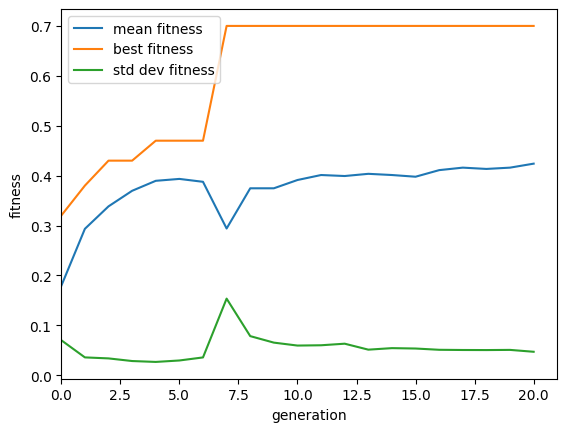

Alice won 32 times
Bob won 68 times


In [189]:
heaps = Nim(N_HEAPS)
solution = evolve_nim_strategy(heaps, GEN_NUM, POP_SIZE, OFFSPR_NUM, n_games=N_GAMES, ext_cnt=7, surv_frac=0.2, niches=3, migr_frac=0.1)

# test it on a match against a nim-sum strategy
Alice = EvolutionalPlayer("Alice", solution, evolved_strategy)
Bob = Player("Bob", nim_sum_strategy)
winners = match( Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

## Task3.3 MinMax

In [190]:
class GameNode:
    def __init__(self, state: list, parent=None, children: list = None):
        self._state = state
        self._parent = parent
        self._children = children
        self._value = 0

    def __hash__(self):
        return hash(bytes(self._state))

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, val):
        self._value = val

    @property
    def parent(self):
        return self._parent

    @parent.setter
    def parent(self, val):
        self._parent = val

    @property
    def children(self):
        return self._children

    def add_child(self, child):
        self._children.append(child)

    @property
    def state(self):
        return self._state

def heap_distance(node: GameNode):
    # the number of plies to the end of the game using a nim-sum strategy
    # negative if the player loses, positive if the player wins
    this_player = Player("this_player", nim_sum_strategy)
    opponent = Player("opponent", nim_sum_strategy)
    winner = play(this_player, opponent, Nim(rows=copy.deepcopy(node.state)))
    if winner.name == this_player.name:
        return winner.n_plies
    else:   # the opponent won
        return -winner.n_plies


def heuristic(node: GameNode, hash_table: dict):
    # check if the value of the state has been already computed
    h = hash_table.get(node)
    if h is None:
        h = heap_distance(node)  # heuristic formula
        if h == 0:
            h = float('inf')
        else:
            h = 1/h
        hash_table[node] = h  # insert in hash_table for later use
    return h


def minmax(node: GameNode, depth: int, maximising: bool, hash_table: dict):
    if depth == 0:
        if sum(node.state) == 0: # if the node is a terminal state like [0, 0, 0]
            if maximising:
                node.value = float('inf') # i won because the opponent had like [0, 1, 0] and took the last object
            else:
                node.value = -float('inf') # i lost
        else:
            node.value = heuristic(node, hash_table)
        return node.value
    if maximising:
        node.value = -float('inf')
        for c in node.children:
            node.value = max(node.value, minmax(c, depth-1, False, hash_table))
        return node.value
    else:
        node.value = float('inf')
        for c in node.children:
            node.value = min(node.value, minmax(c, depth-1, True, hash_table))
        return node.value


def game_tree(state: list, parent: GameNode, depth: int) -> GameNode:
    this_node = GameNode(state, parent, list())
    if depth > 0:
        for i in range(len(state)):
            # list all the possible new sizes of the heap state[i]
            for j in range(state[i]):
                child_state = copy.deepcopy(state)
                child_state[i] = j
                this_node.add_child(game_tree(child_state, this_node, depth-1))
    return this_node

class MinMaxPlayer(Player):
    def __init__(self, name, strategy, look_ahead):
        super().__init__(name, strategy)
        self._hash_table = {}
        self._look_ahead = look_ahead

    def flush_parameters(self):
        self._hash_table = {}
        super().flush_parameters()

    @property
    def hash_table(self):
        return self._hash_table
    
    @property
    def look_ahead(self):
        return self._look_ahead

def minmax_strategy(player: MinMaxPlayer, heaps: Nim):
    depth = player.look_ahead*2  # depth of the tree is the double of plies look ahead

    # generate game tree, access it through the root
    root = game_tree(heaps.rows, None, depth)

    # apply minmax algorithm, return the heuristic value of the action to be taken
    chosen_value = minmax(root, depth, True, player.hash_table)

    # select actions
    viable_children_idxs = [i for i, c in enumerate(
        root.children) if c.value == chosen_value]
    chosen_child_idx = random.choice(viable_children_idxs)
    chosen_child = root.children[chosen_child_idx]

    # compute the heap idx and the number of object to take
    difference = [i-j for i, j in zip(root.state, chosen_child.state)]
    num_objects = max(difference)
    chosen_heap = difference.index(num_objects)

    # nim the heap
    heaps.nimming(chosen_heap, num_objects, player)


In [191]:
# minmax vs random
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice", minmax_strategy, 1)
Bob = Player("Bob", random_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice won 42 times
Bob won 58 times


In [192]:
# minmax vs minmax
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice", minmax_strategy, 1)
Bob = MinMaxPlayer("Bob", minmax_strategy, 1)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice won 60 times
Bob won 40 times


In [193]:
# minmax vs nimsum
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice", minmax_strategy, 1)
Bob = Player("Bob", nim_sum_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice won 0 times
Bob won 100 times
